In [2]:
import time
import datetime
import pandas as pd
import numpy as np
import subprocess
import re
from IPython.display import display, HTML, clear_output
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import hex2color
from matplotlib.dates import HourLocator, MinuteLocator, DateFormatter

def project_winner(row):
    if row.winner != '':
        return row.winner
    else:
        return 'Projected ' + row.projected_winner

class CommandExecutor:
    def execute(self, command):
        #print 'Executing: ' + command
        ret_code = subprocess.call(command, shell=True)
        if ret_code != 0:
            raise OSError('Command ' + command + ' failed: ' + str(ret_code))
            
def party_color(s):
    if type(s) in (str):
        s = re.sub(' (gain from [A-Za-z]*|hold)$', '', s)
        if (palette.party == s).any():
            col = palette.loc[palette.party == s, 'col'].values[0]
            bg_col = palette.loc[palette.party == s, 'bg_col'].values[0]

            return 'color: {0}; background-color:{1}'.format(col, bg_col)
        else:
            return ''
    else:
        return ''

def color_table(row):
    called = ('Projected' not in row.combined_winner)
    output = [party_color(cell) for cell in row]
    if called:
        output[0] = 'background-color: yellow'
    return output

def side_by_side_tables(stylers):
    output = []
    for s in stylers:
        html_string = s.render()
        soup = BeautifulSoup(html_string, "lxml")
        soup.find('table')['width'] = '800'
        output.append('<div style="float: left">{0}</div>'.format(str(soup)))
    output = ''.join(output)
    return(display(HTML(output)))

display(HTML("<style>.container { width:100% !important;}</style>"))
pd.set_option('display.max_rows', 650)

%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

United Kingdom General Election, June 8, 2017
Last Updated: 17:41 EST / 22:41 BST


,Projected Seats,Change,North East,Yorkshire and The Humber,North West,East Midlands,West Midlands,East,London,South East,South West,Wales,Scotland
Conservative,321,-9,3.0,17.0,21.0,31.0,36.0,50.0,22.0,72.0,48.0,8.0,13.0
Labour,258,26,26.0,37.0,53.0,15.0,23.0,7.0,48.0,8.0,6.0,28.0,7.0
SNP,35,-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0
LibDem,13,5,0.0,0.0,1.0,0.0,0.0,1.0,3.0,2.0,1.0,1.0,4.0
PC,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
Green,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Ind,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
UKIP,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


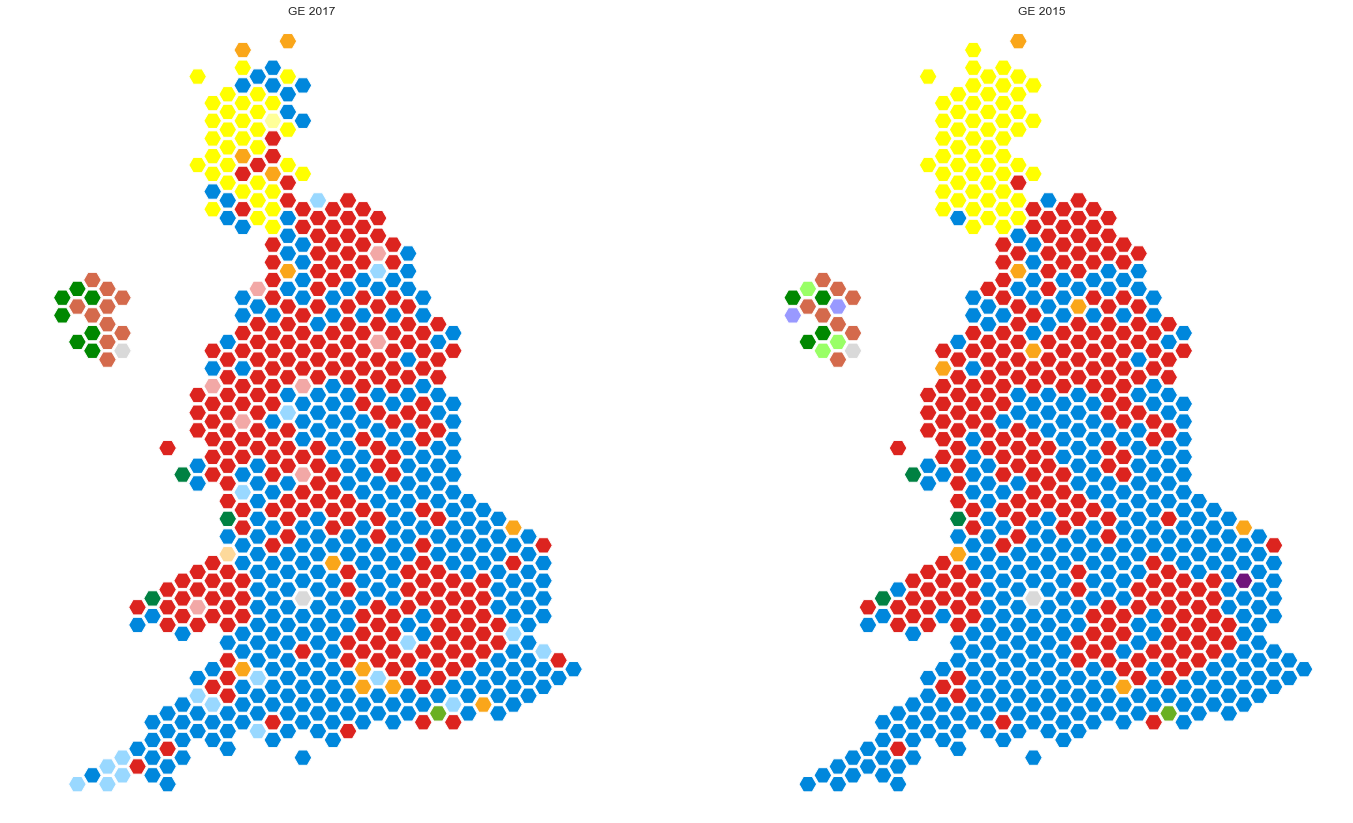

In [6]:
print('United Kingdom General Election, June 8, 2017' + '\nLast Updated: ' + datetime.datetime.now().strftime('%H:%M') + ' EST / ' + (datetime.datetime.now() + datetime.timedelta(hours = 5)).strftime('%H:%M') + ' BST')

ge2017 = pd.read_csv('ge2017.csv').fillna('')
ge2015 = pd.read_csv('ge2015.csv').fillna('')
palette = pd.read_csv('palette.csv')
shape_df = pd.read_csv('constituency_hex.csv', sep = '|')
projection_grid = pd.read_csv('projection_grid.csv').fillna('')

timestamp = datetime.datetime.now().strftime('%m%d%H%M%S')
command = 'cp ge2017.csv archive/{0}'.format('ge2017_' + timestamp + '.csv')
CommandExecutor().execute(command)

shape_df.points = shape_df.points.apply(eval)
projection = projection_grid.loc[projection_grid['winner'] != ''].groupby(['id', 'constituency', 'winner']).sum().reset_index()
projection = projection[projection.groupby(['id', 'constituency'])['score'].transform(max) == projection['score']][['id', 'constituency', 'winner']].rename(columns = {'winner': 'projected_winner'})
live_data = pd.merge(ge2017, projection, how = 'left', on =['id', 'constituency'])[[u'id', u'constituency', u'region', u'country', u'majority_15', u'last_winner', u'projected_winner',u'winner', 'change']]
live_data['combined_winner'] = live_data.apply(project_winner, axis = 1)
live_data['party'] = live_data['combined_winner'].str.replace('Projected ', '')

#marginal table transform
party_list = [u'Conservative',u'Labour', u'UKIP', u'LibDem', u'SNP', u'Green', u'DUP', u'PC', u'SF',u'UUP', u'SDLP', u'Ind', u'Alliance', u'Other']
upper_margin = {k:v for (k, v) in zip(party_list, [6] * len(party_list))}
upper_margin['UKIP'] = 4
upper_margin['PC'] = 8
upper_margin['LibDem'] = 8
upper_margin['Conservative'] = 8
upper_margin['SNP'] = 2
upper_margin['Labour'] = 12
lower_margin = {k:v for (k, v) in zip(party_list, [6] * len(party_list))}
lower_margin['UKIP'] = 10
lower_margin['Labour'] = 8
lower_margin['SNP'] = 20
lower_margin['Conservative'] = 12

battleground = {}
for party in party_list:
    battleground[party+'_defence'] = (ge2015['id'][((ge2015['last_winner'] == party) & (ge2015['majority_pct'] < lower_margin[party]))].append(live_data['id'][(live_data['last_winner'] == party) & ~(live_data['combined_winner'].str.contains(party))]).unique()).tolist()
    battleground[party+'_target'] = (ge2015['id'][((ge2015['last_winner'] != party) & ((ge2015['last_winner_pct'] - ge2015[party]) < upper_margin[party]))].append(live_data['id'][(live_data['last_winner'] != party) & (live_data['combined_winner'].str.contains(party))]).unique()).tolist()

scotland_marginal = list(set([j for i in battleground.values() for j in i if j.startswith('S')] + list(live_data.loc[(live_data['region'] == 'Scotland') & (live_data.party != live_data.last_winner),'id'])))
wales_marginal = list(set([j for i in battleground.values() for j in i if j.startswith('W')] + list(live_data.loc[(live_data['region'] == 'Wales') & (live_data.party != live_data.last_winner),'id'])))
ni_marginal = list(set([j for i in battleground.values() for j in i if j.startswith('N')] + list(live_data.loc[(live_data['region'] == 'Northern Ireland') & (live_data.party != live_data.last_winner),'id'])))

#map transform
shape_df = pd.merge(shape_df, live_data[['id', 'combined_winner']], on = 'id').merge(palette, how = 'left', left_on = 'combined_winner', right_on = 'party')
shape_df = pd.merge(shape_df, live_data[['id', 'last_winner']], on = 'id').merge(palette, how = 'left', left_on = 'last_winner', right_on = 'party', suffixes=('', '_15'))

#linechart transform
new_entry = pd.DataFrame(live_data.party.value_counts()).transpose()
new_entry.index = [datetime.datetime.now()]
#ts_projected = pd.read_csv('ts_projected.csv', index_col = 0); ts_projected.index = [datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S.%f") for t in ts_projected.index]

try:
    ts_projected = pd.concat([ts_projected, new_entry]).fillna(0)
except NameError:
    ts_projected = new_entry

ts_projected.to_csv('ts_projected.csv')

new_entry = pd.DataFrame(live_data[live_data.winner != ''].winner.value_counts()).transpose()
new_entry.index = [datetime.datetime.now()]

try:
    ts_declared = pd.concat([ts_declared, new_entry]).fillna(0)
except NameError:
    ts_declared = new_entry

ts_declared.to_csv('ts_declared.csv')

summary = pd.DataFrame(live_data[~live_data.region.isin(['Northern Ireland'])].party.value_counts()).rename(columns = {'party': 'Projected Seats'}).join(live_data[~live_data.region.isin(['Northern Ireland'])].last_winner.value_counts(), how = 'outer').fillna(0)
summary = summary.apply(lambda x: x.astype('int'))
summary['Change'] = summary['Projected Seats'] - summary['last_winner']
summary = summary[['Projected Seats', 'Change']]

regional_idx = ['North East', 'Yorkshire and The Humber', 'North West', 'East Midlands', 'West Midlands', 'East', 'London', 'South East', 'South West', 'Wales', 'Scotland']
regional_summary = pd.pivot_table(live_data.groupby(['region', 'party']).count().reset_index(), index = 'party', columns = 'region', values = 'winner', fill_value = 0).rename_axis(None, axis=1).reset_index().set_index('party').rename_axis(None, axis=0)[regional_idx]
summary = summary.join(regional_summary).sort_values('Projected Seats', ascending = False)

display(summary)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(24, 24))

patches = []

for i in range(0, shape_df.shape[0]):
    polygon = Polygon(shape_df.points[i], True, fc = hex2color(shape_df.bg_col[i]), ec = hex2color('#ffffff'))
    patches.append(polygon)

p = PatchCollection(patches, match_original=True)

ax.add_collection(p)

ax.set_ylim([64, 80])
ax.set_xlim([-9, 3.25])
ax.set_aspect(1)
ax.axis('off')
ax.set_title('GE 2017')

patches2 = []

for i in range(0, shape_df.shape[0]):
    polygon = Polygon(shape_df.points[i], True, fc = hex2color(shape_df.bg_col_15[i]), ec = hex2color('#ffffff'))
    patches2.append(polygon)

p2 = PatchCollection(patches2, match_original=True)

ax2.add_collection(p2)

ax2.set_ylim([64, 80])
ax2.set_xlim([-9, 3.25])
ax2.set_aspect(1)
ax2.axis('off')
ax2.set_title('GE 2015')

plt.show()